In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import optuna
from optuna.integration import OptunaSearchCV

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# 1. EDA

In [7]:
df = pd.read_csv('C:/Users\/juanm/Escritorio/Juanmi/DataFest IKEA/Team 09. ImportBilly/1. Data/visits_train.csv', parse_dates=[1])
df.head()

C:\Users\juanm\AppData\Local\Temp\ipykernel_9932\2388807926.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('C:/Users\/juanm/Escritorio/Juanmi/DataFest IKEA/Team 09. ImportBilly/1. Data/visits_train.csv', parse_dates=[1])


,location,date_visit,visits
0,Madrid,2023-02-28,67.323720
1,Madrid,2023-02-27,71.894430
2,Madrid,2023-02-26,87.803810
3,Madrid,2023-02-25,90.435243
4,Madrid,2023-02-24,76.281122


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   location    1338 non-null   object        
 1   date_visit  1338 non-null   datetime64[ns]
 2   visits      1338 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.5+ KB


In [9]:
df.describe()

,date_visit,visits
count,1338,1338.000000
mean,2022-03-31 00:00:00,58.837301
min,2021-05-01 00:00:00,0.000000
25%,2021-10-15 00:00:00,50.429277
50%,2022-03-31 00:00:00,59.213881
75%,2022-09-14 00:00:00,67.605966
max,2023-02-28 00:00:00,101.000000
std,NaN,16.243328


In [18]:
miss_data = pd.isnull(df).values.any()
print("Hay información perdida: ", miss_data, "\n")

sum_miss_data = pd.isnull(df).sum()
print("Hay {} valores perdidos".format(sum_miss_data))

Hay información perdida:  False 

Hay location      0
date_visit    0
visits        0
dtype: int64 valores perdidos


In [19]:
# Duplicates
df.duplicated().value_counts()

False    1338
Name: count, dtype: int64

In [22]:
# Porcentaje de ceros
variables = ['location', 'date_visit', 'visits']
for i in variables:
    df_count=df.loc[df[i] == 0]
    x=(df_count[i].count()/df[i].count())*100
    x=round(x,2)
    print(f'The Number of zero values in column {i} is {x}')

The Number of zero values in column location is 0.0
The Number of zero values in column date_visit is 0.0
The Number of zero values in column visits is 2.62


Diferenciamos entre Madrid y Barcelona

In [12]:
df_mad = df[df['location']=='Madrid'][['date_visit', 'visits']]

In [13]:
df_bar = df[df['location']=='Barcelona'][['date_visit', 'visits']]

Graficamos ambas series temporales

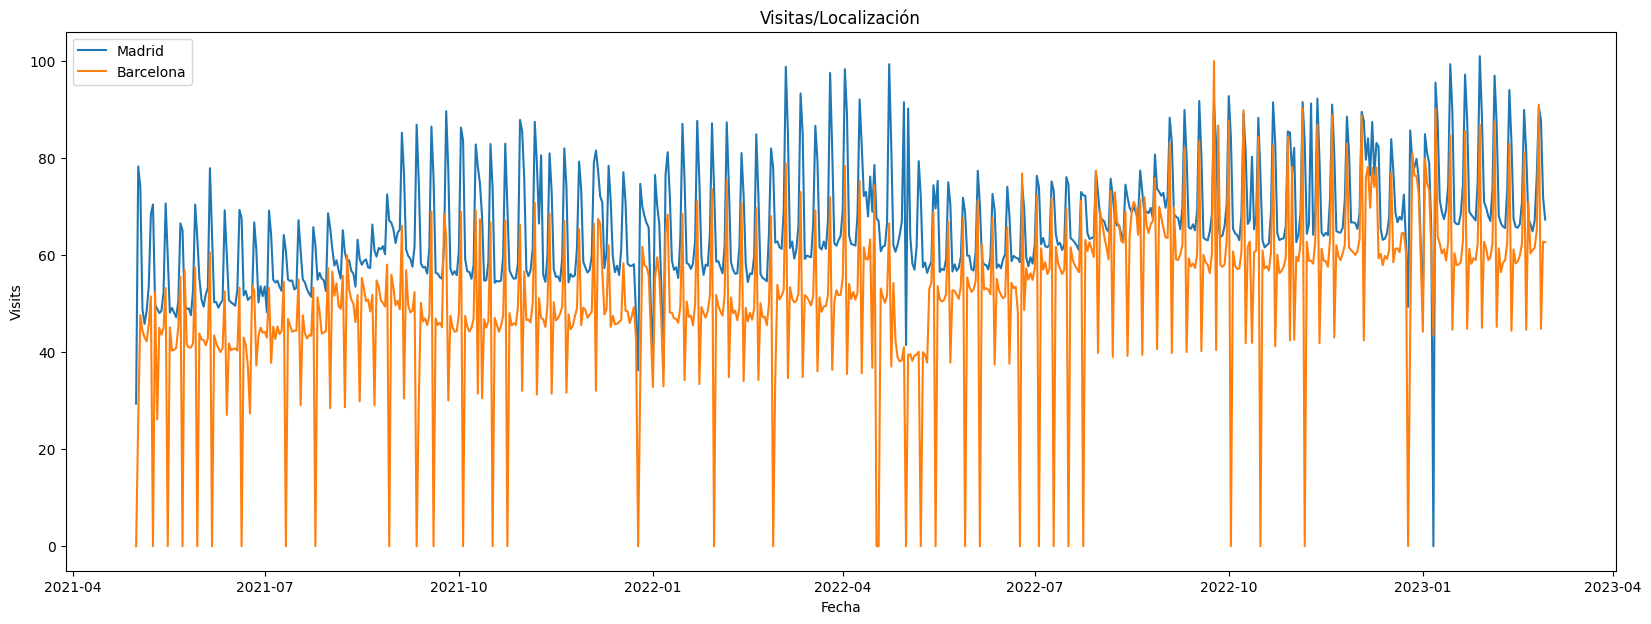

In [17]:
# Graficamos ambas TS
plt.figure(figsize=(20, 7))
plt.plot(df_mad.date_visit, df_mad['visits'], label='Madrid')
plt.plot(df_bar.date_visit, df_bar['visits'], label='Barcelona')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Localización')
plt.legend()
plt.show()

Asumiendo que en los datos se tienen en cuenta TODAS las tiendas que pertenecen a cada una de las ciudades, una primera conclusión es que en Barcelona tenemos muchos más días que no acude nadie a las tiendas (tiendas cerradas) ya que Barcelona tiene muchas menos tiendas que Madrid.

# 2.0 Modelo Simple

Para este modelo, vamos a diferenciar entre Madrid y Barcelona, es decir, utilizamos los dataframes df_mad y df_barc

* Madrid

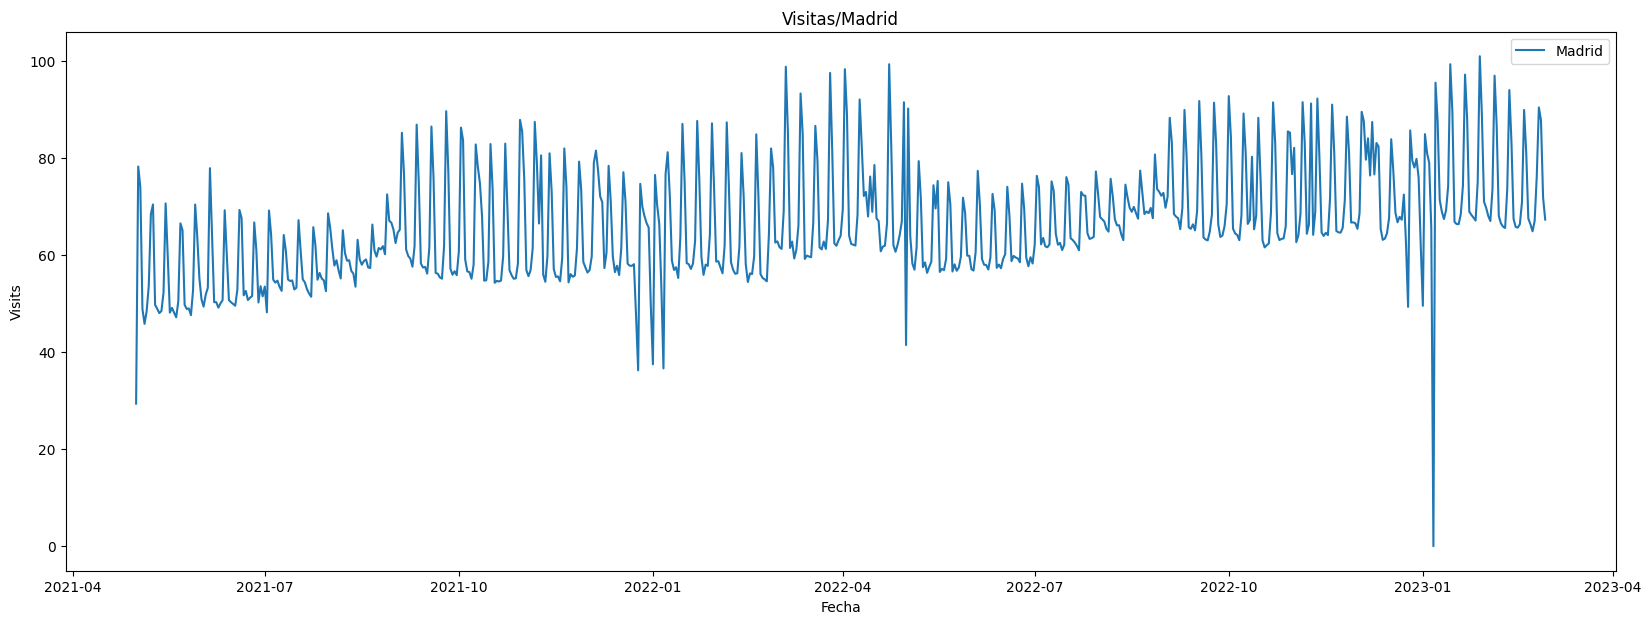

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(df_mad.date_visit, df_mad['visits'], label='Madrid')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Madrid')
plt.legend()
plt.show()

Comprobamos la varianza

In [32]:
x = df_mad['visits']

ValueError: Data must be positive.

* Barcelona

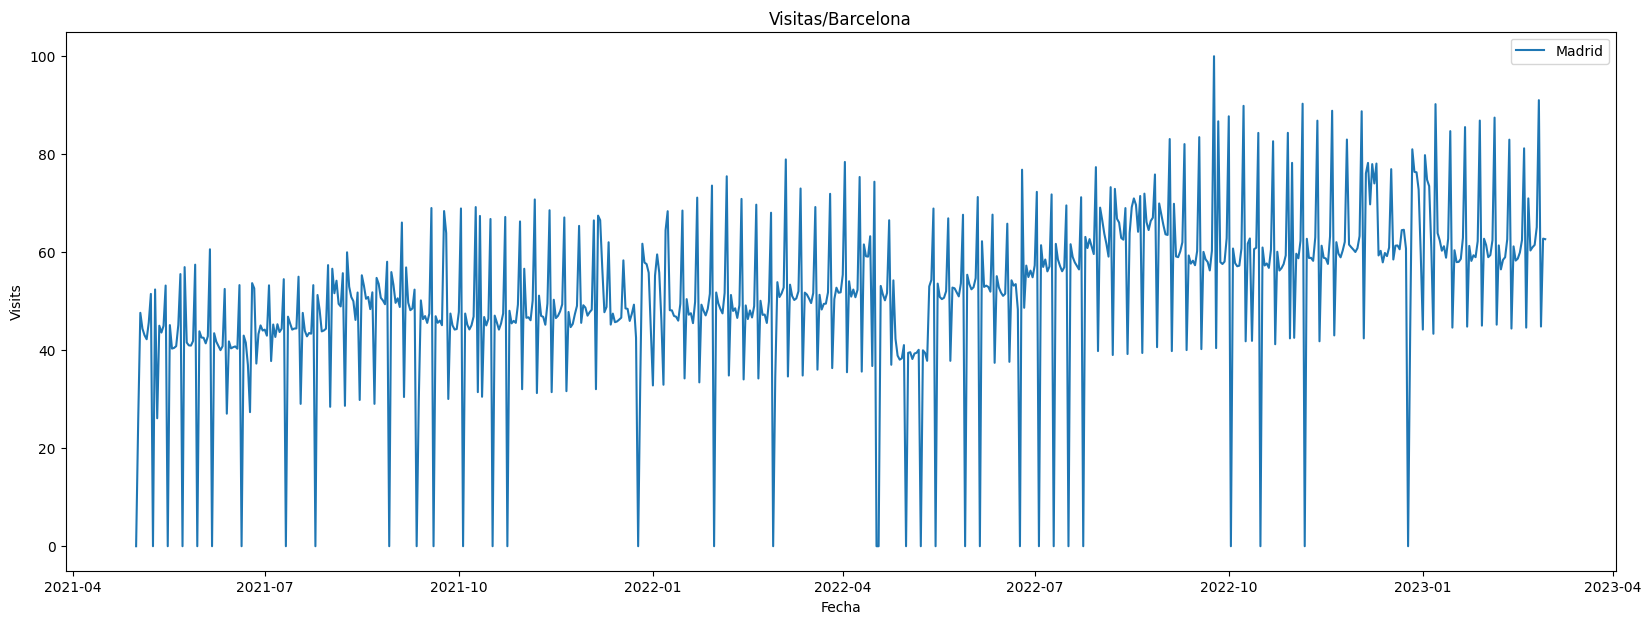

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(df_bar.date_visit, df_bar['visits'], label='Madrid')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Barcelona')
plt.legend()
plt.show()